# Shallow embedding methods

## Setup

In [ ]:
!pip install git+https://github.com/palash1992/GEM.git
!pip install karateclub
!pip install node2vec
!pip install python-Levenshtein
!pip install gensim==3.8.0
!pip install -U Ipython

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from gem.embedding.gf import GraphFactorization
from karateclub.node_embedding.neighbourhood.grarep import GraRep
from gem.embedding.hope import HOPE
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk
from node2vec import Node2Vec
import random
from IPython.display import Code
import inspect
from karateclub import Graph2Vec
from node2vec.edges import HadamardEmbedder

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Theory

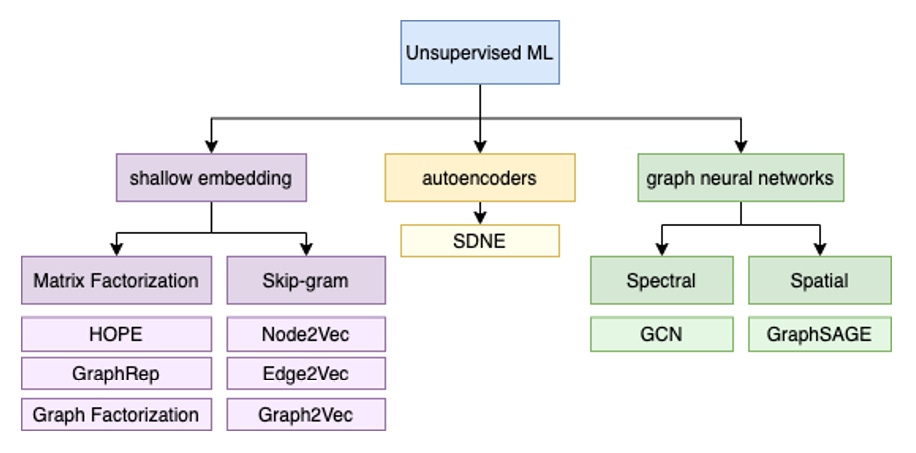

**Shallow embedding methods**

These methods are able to learn and return only the embedding values for the learned input data. Generally speaking, all the unsupervised embedding algorithms based on matrix factorization use the same principle. They all factorize an input graph expressed as a matrix in different components (commonly knows as matrix factorization). The main difference between each method lies in the loss function used during the optimization process. Indeed, different loss functions allow creating an embedding space that emphasizes specific properties of the input graph.

## Graph Factorization

The GF algorithm was one of the first models to reach good computational performance in order to perform the node embedding of a given graph. The loss function used in this method was mainly designed to improve GF performances and scalability. Indeed, the solution generated by this method could be noisy. Moreover, it should be noted, by looking at its matrix factorization formulation, that GF performs a strong symmetric factorization. This property is particularly suitable for undirected graphs, where the adjacency matrix is symmetric, but could be a potential limitation for undirected graphs.

In [ ]:
Code(inspect.getsource(GraphFactorization), language='python')

class GraphFactorization(StaticGraphEmbedding):

    """`Graph Factorization`_.
    Graph Factorization factorizes the adjacency matrix with regularization.
    
    Args:
        hyper_dict (object): Hyper parameters.
        kwargs (dict): keyword arguments, form updating the parameters
    
    Examples:
        >>> from gemben.embedding.gf import GraphFactorization
        >>> edge_f = 'data/karate.edgelist'
        >>> G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=False)
        >>> G = G.to_directed()
        >>> res_pre = 'results/testKarate'
        >>> graph_util.print_graph_stats(G)
        >>> t1 = time()
        >>> embedding = GraphFactorization(2, 100000, 1 * 10**-4, 1.0)
        >>> embedding.learn_embedding(graph=G, edge_f=None,
                                  is_weighted=True, no_python=True)
        >>> print ('Graph Factorization:Training time: %f' % (time() - t1))
        >>> viz.plot_embedding2D(embedding.get_embedding(),
                             di_graph=G, node_colors=None)
        >>> plt.show()
    .. _Graph Factorization:
        https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/40839.pdf
    """

    def __init__(self, *hyper_dict, **kwargs):
        ''' Initialize the GraphFactorization class
        Args:
            d: dimension of the embedding
            eta: learning rate of sgd
            regu: regularization coefficient of magnitude of weights
            max_iter: max iterations in sgd
            print_step: #iterations to log the prgoress (step%print_step)
        '''
        hyper_params = {
            'print_step': 10000,
            'method_name': 'graph_factor_sgd'
        }
        hyper_params.update(kwargs)
        for key in hyper_params.keys():
            self.__setattr__('_%s' % key, hyper_params[key])
        for dictionary in hyper_dict:
            for key in dictionary:
                self.__setattr__('_%s' % key, dictionary[key])

    def get_method_name(self):
        return self._method_name

    def get_method_summary(self):
        return '%s_%d' % (self._method_name, self._d)

    def _get_f_value(self, graph):
        f1 = 0
        for i, j, w in graph.edges(data='weight', default=1):
            f1 += (w - np.dot(self._X[i, :], self._X[j, :]))**2
        f2 = self._regu * (np.linalg.norm(self._X)**2)
        return [f1, f2, f1 + f2]

    def learn_embedding(self, graph=None, edge_f=None,
                        is_weighted=False, no_python=True):
        c_flag = True
        if not graph and not edge_f:
            raise Exception('graph/edge_f needed')
        if no_python:
            if sys.platform[0] == "w":
                args = ["gem/c_exe/gf.exe"]
            else:
                args = ["gem/c_exe/gf"]
            if not graph and not edge_f:
                raise Exception('graph/edge_f needed')
            if edge_f:
                graph = graph_util.loadGraphFromEdgeListTxt(edge_f)
            graphFileName = 'gem/intermediate/%s_gf.graph' % self._data_set
            embFileName = 'gem/intermediate/%s_%d_gf.emb' % (self._data_set, self._d)
            # try:
                # f = open(graphFileName, 'r')
                # f.close()
            # except IOError:
            graph_util.saveGraphToEdgeListTxt(graph, graphFileName)
            args.append(graphFileName)
            args.append(embFileName)
            args.append("1")  # Verbose
            args.append("1")  # Weighted
            args.append("%d" % self._d)
            args.append("%f" % self._eta)
            args.append("%f" % self._regu)
            args.append("%d" % self._max_iter)
            args.append("%d" % self._print_step)
            t1 = time()
            try:
                call(args)
            except Exception as e:
                print(str(e))
                c_flag = False
                print('./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable 

In [ ]:
Path("gem/intermediate").mkdir(parents=True, exist_ok=True)

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)

In [ ]:
gf = GraphFactorization(d=2, data_set=None, max_iter=10000, eta=1*10**-4, regu=1.0)
gf.learn_embedding(G)

[Errno 2] No such file or directory: 'gem/c_exe/gf': 'gem/c_exe/gf'
./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission
		Iter id: 0, Objective: 95.0017, f1: 94.9973, f2: 0.00438617


(array([[0.00451367, 0.00223718],
        [0.00451454, 0.00223614],
        [0.0045092 , 0.00223504],
        [0.00450067, 0.00223724],
        [0.00449324, 0.00227416],
        [0.00454065, 0.00217207],
        [0.0046062 , 0.00198754],
        [0.00488981, 0.00318883],
        [0.0055224 , 0.00082217],
        [0.00071636, 0.00328242],
        [0.00203305, 0.00143283],
        [0.0095666 , 0.00390468],
        [0.00988249, 0.00352899],
        [0.00894197, 0.00033567],
        [0.01429165, 0.00202801],
        [0.01429365, 0.00202709],
        [0.01429462, 0.0020306 ],
        [0.0142912 , 0.00202897],
        [0.01424044, 0.00209048],
        [0.01435705, 0.00199515],
        [0.0144582 , 0.00155144],
        [0.01358546, 0.00269956],
        [0.01549333, 0.00223387],
        [0.0199567 , 0.00036844]]),
 13.623228073120117)

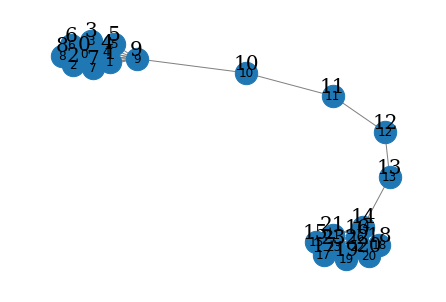

In [ ]:
draw_graph(G)

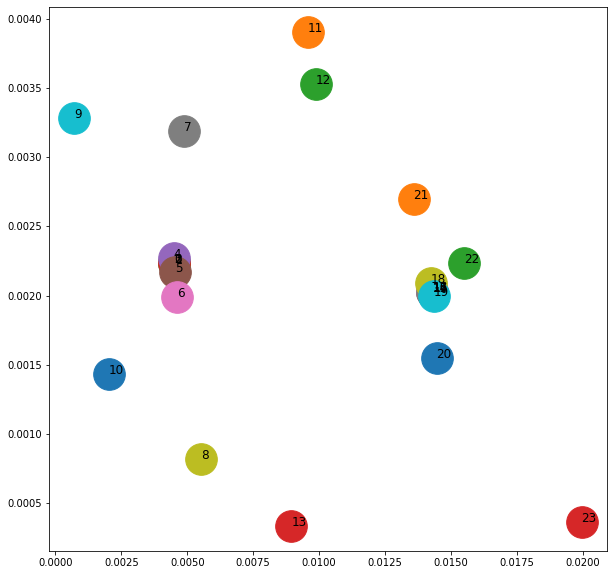

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## GraphRep

Graph representation with global structure information (GraphRep), such as HOPE, allows us to preserve higher-order proximity without forcing its embeddings to have symmetric properties.

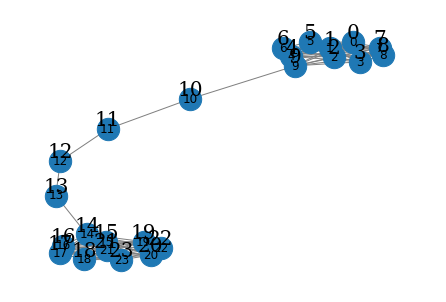

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

We initialize the GraRep class from the karateclub library. In this implementation, the dimension parameter represents the dimension of the embedding space, while the order parameter defines the maximum number of orders of proximity between nodes. The number of columns of the final embedding matrix (stored, in the example, in the embeddings variable) is `dimension x order`, since, as we said, for each proximity order an embedding is computed and concatenated in the final embedding matrix.

In [ ]:
gr = GraRep(dimensions=2,order=3)
gr.fit(G)

In [ ]:
embeddings = gr.get_embedding()
embeddings.shape

(24, 6)

To specify, since two dimensions are computed in the example, embeddings[:,:2] represents the embedding obtained for k=1, embeddings[:,2:4] for k=2, and embeddings[:,4:] for k=3. The results of the code are shown in the following graph:

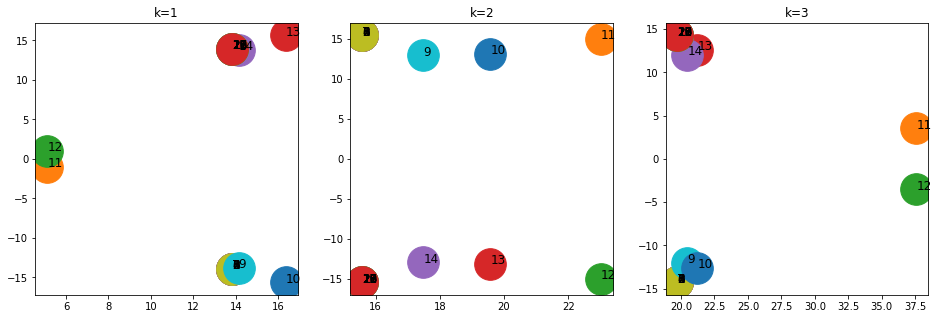

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

for x in G.nodes():
    v = gr.get_embedding()[x]
    ax[0].scatter(v[0],v[1], s=1000)
    ax[0].annotate(str(x), (v[0],v[1]), fontsize=12)
    ax[0].set_title('k=1')
    ax[1].scatter(v[2],v[3], s=1000)
    ax[1].annotate(str(x), (v[2],v[3]), fontsize=12)
    ax[1].set_title('k=2')
    ax[2].scatter(v[4],v[5], s=1000)
    ax[2].annotate(str(x), (v[4],v[5]), fontsize=12)
    ax[2].set_title('k=3')

plt.show()

## HOPE

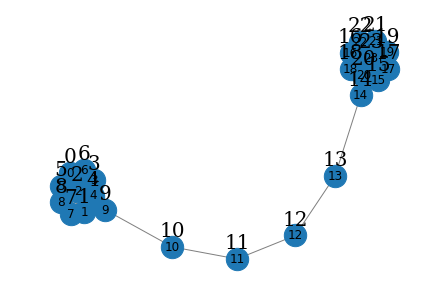

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G)

SVD error (low rank): 0.052092


(array([[ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07024409,  0.07024348,  0.07024409,  0.07024348],
        [ 0.07104037,  0.07104201,  0.07104037,  0.07104201],
        [ 0.00797181,  0.00799433,  0.00797181,  0.00799433],
        [ 0.00079628,  0.00099787,  0.00079628,  0.00099787],
        [-0.00079628,  0.00099787, -0.00079628,  0.00099787],
        [-0.00797181,  0.00799433, -0.00797181,  0.00799433],
        [-0.07104037,  0.07104201, -0.07104037,  0.07104201],
        [-0.07024409,  0.07024348, -0.07024409,  0.07024348],
        

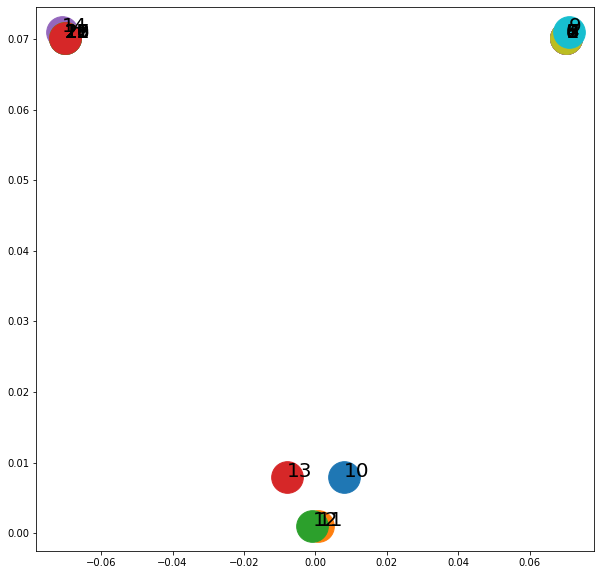

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = hp.get_embedding()[x,2:]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=20)

## DeepWalk

*fig: All the steps used by the DeepWalk algorithm to generate the node embedding of a given graph*

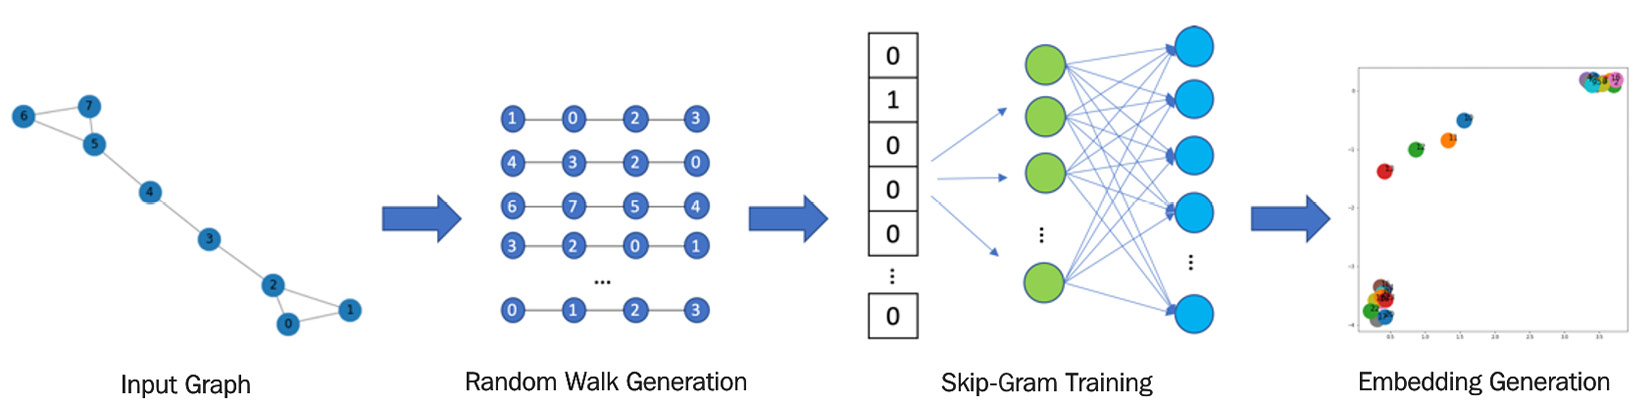

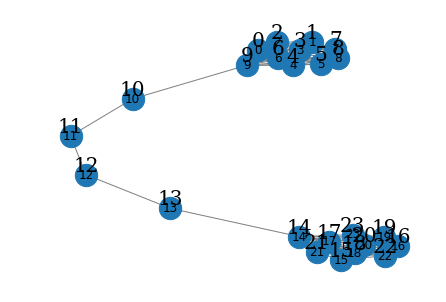

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
Code(inspect.getsource(DeepWalk), language='python')

class DeepWalk(Estimator):
    r"""An implementation of `"DeepWalk" <https://arxiv.org/abs/1403.6652>`_
    from the KDD '14 paper "DeepWalk: Online Learning of Social Representations".
    The procedure uses random walks to approximate the pointwise mutual information
    matrix obtained by pooling normalized adjacency matrix powers. This matrix
    is decomposed by an approximate factorization technique.

    Args:
        walk_number (int): Number of random walks. Default is 10.
        walk_length (int): Length of random walks. Default is 80.
        dimensions (int): Dimensionality of embedding. Default is 128.
        workers (int): Number of cores. Default is 4.
        window_size (int): Matrix power order. Default is 5.
        epochs (int): Number of epochs. Default is 1.
        learning_rate (float): HogWild! learning rate. Default is 0.05.
        min_count (int): Minimal count of node occurrences. Default is 1.
        seed (int): Random seed value. Default is 42.
    """
    def __init__(self, walk_number: int=10, walk_length: int=80, dimensions: int=128,
                 workers: int=4, window_size: int=5, epochs: int=1,
                 learning_rate: float=0.05, min_count: int=1, seed: int=42):

        self.walk_number = walk_number
        self.walk_length = walk_length
        self.dimensions = dimensions
        self.workers = workers
        self.window_size = window_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.seed = seed

    def fit(self, graph: nx.classes.graph.Graph):
        """
        Fitting a DeepWalk model.

        Arg types:
            * **graph** *(NetworkX graph)* - The graph to be embedded.
        """
        self._set_seed()
        graph = self._check_graph(graph)
        walker = RandomWalker(self.walk_length, self.walk_number)
        walker.do_walks(graph)

        model = Word2Vec(walker.walks,
                         hs=1,
                         alpha=self.learning_rate,
                         epochs=self.epochs,
                         vector_size=self.dimensions,
                         window=self.window_size,
                         min_count=self.min_count,
                         workers=self.workers,
                         seed=self.seed)

        num_of_nodes = graph.number_of_nodes()
        self._embedding = [model.wv[str(n)] for n in range(num_of_nodes)]


    def get_embedding(self) -> np.array:
        r"""Getting the node embedding.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of nodes.
        """
        return np.array(self._embedding)

In [ ]:
dw = DeepWalk(dimensions=2)
dw.fit(G)

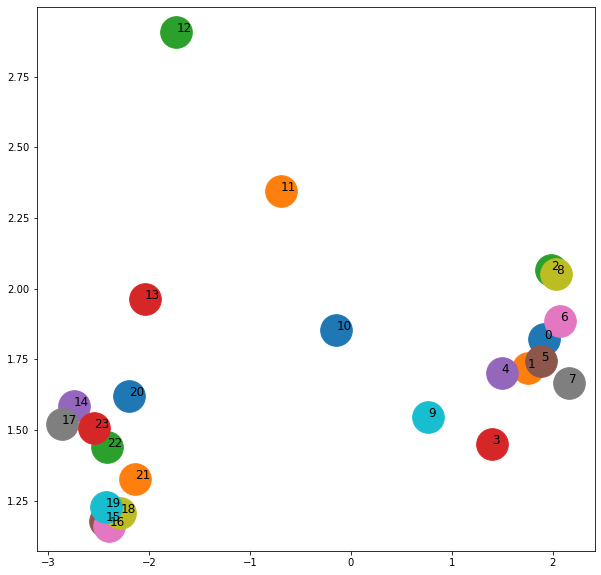

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = dw.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

## Node2Vec

The Node2Vec algorithm can be seen as an extension of DeepWalk. Indeed, as with DeepWalk, Node2Vec also generates a set of random walks used as input to a skip-gram model. Once trained, the hidden layers of the skip-gram model are used to generate the embedding of the node in the graph. The main difference between the two algorithms lies in the way the random walks are generated.

Indeed, if DeepWalk generates random walks without using any bias, in Node2Vec a new technique to generate biased random walks on the graph is introduced. The algorithm to generate the random walks combines graph exploration by merging Breadth-First Search (BFS) and Depth-First Search (DFS). The way those two algorithms are combined in the random walk's generation is regularized by two parameters p, and q. p defines the probability of a random walk getting back to the previous node, while q defines the probability that a random walk can pass through a previously unseen part of the graph.

Due to this combination, Node2Vec can preserve high-order proximities by preserving local structures in the graph as well as global community structures. This new method of random walk generation allows solving the limitation of DeepWalk preserving the local neighborhood properties of the node.

In [ ]:
Code(inspect.getsource(Node2Vec), language='python')

class Node2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if cur

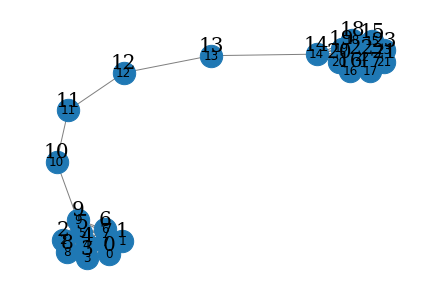

In [ ]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

In [ ]:
node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)
embeddings = model.wv

Generating walks (CPU: 1):  20%|██        | 2/10 [00:00<00:00, 16.61it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


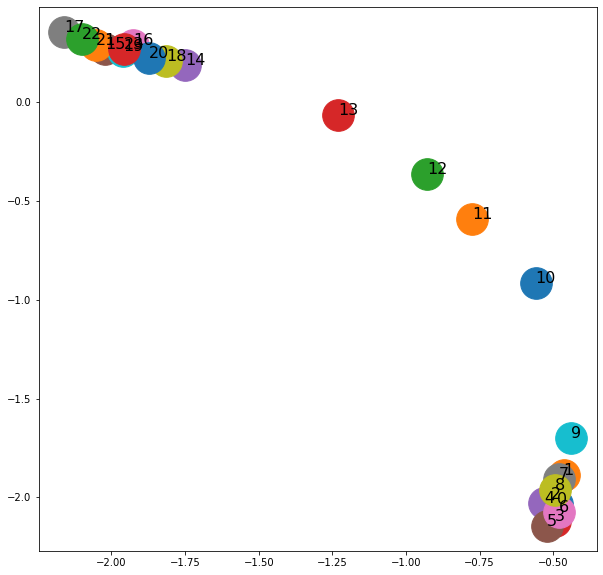

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    
    v = model.wv[str(x)]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

## Edge2Vec

Contrary to the other embedding function, the Edge to Vector (Edge2Vec) algorithm generates the embedding space on edges, instead of nodes. This algorithm is a simple side effect of the embedding generated by using Node2Vec. The main idea is to use the node embedding of two adjacent nodes to perform some basic mathematical operations in order to extract the embedding of the edge connecting them.

The operators described in the below table can be used in order to compute the embedding of their edge:

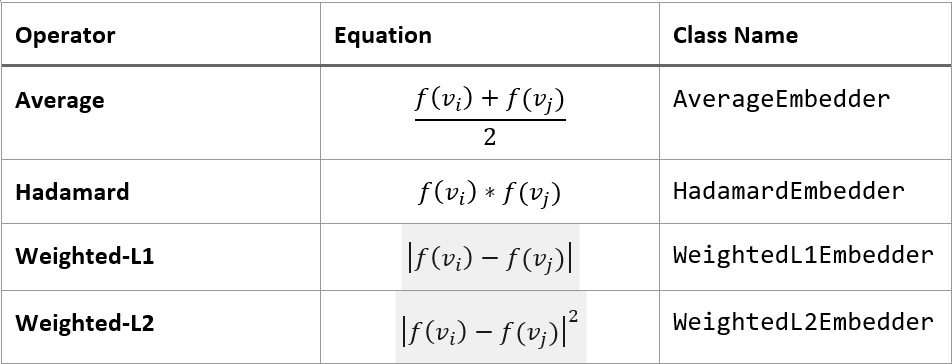

In [ ]:
Code(inspect.getsource(HadamardEmbedder), language='python')

class HadamardEmbedder(EdgeEmbedder):
    """
    Hadamard product node features
    """

    def _embed(self, edge: tuple):
        return self.kv[edge[0]] * self.kv[edge[1]]

In [ ]:
from node2vec.edges import EdgeEmbedder
Code(inspect.getsource(EdgeEmbedder), language='python')

class EdgeEmbedder(ABC):
    INDEX_MAPPING_KEY = 'index2word' if pkg_resources.get_distribution("gensim").version < '4.0.0' else 'index_to_key'

    def __init__(self, keyed_vectors: KeyedVectors, quiet: bool = False):
        """
        :param keyed_vectors: KeyedVectors containing nodes and embeddings to calculate edges for
        """

        self.kv = keyed_vectors
        self.quiet = quiet

    @abstractmethod
    def _embed(self, edge: tuple) -> np.ndarray:
        """
        Abstract method for implementing the embedding method
        :param edge: tuple of two nodes
        :return: Edge embedding
        """
        pass

    def __getitem__(self, edge) -> np.ndarray:
        if not isinstance(edge, tuple) or not len(edge) == 2:
            raise ValueError('edge must be a tuple of two nodes')

        if edge[0] not in getattr(self.kv, self.INDEX_MAPPING_KEY):
            raise KeyError('node {} does not exist in given KeyedVectors'.format(edge[0]))

        if edge[1] not in getattr(self.kv, self.INDEX_MAPPING_KEY):
            raise KeyError('node {} does not exist in given KeyedVectors'.format(edge[1]))

        return self._embed(edge)

    def as_keyed_vectors(self) -> KeyedVectors:
        """
        Generated a KeyedVectors instance with all the possible edge embeddings
        :return: Edge embeddings
        """

        edge_generator = combinations_with_replacement(getattr(self.kv, self.INDEX_MAPPING_KEY), r=2)

        if not self.quiet:
            vocab_size = len(getattr(self.kv, self.INDEX_MAPPING_KEY))
            total_size = reduce(lambda x, y: x * y, range(1, vocab_size + 2)) / \
                         (2 * reduce(lambda x, y: x * y, range(1, vocab_size)))

            edge_generator = tqdm(edge_generator, desc='Generating edge features', total=total_size)

        # Generate features
        tokens = []
        features = []
        for edge in edge_generator:
            token = str(tuple(sorted(edge)))
            embedding = self._embed(edge)

            tokens.append(token)
            features.append(embedding)

        # Build KV instance
        edge_kv = KeyedVectors(vector_size=self.kv.vector_size)
        if pkg_resources.get_distribution("gensim").version < '4.0.0':
            edge_kv.add(
                entities=tokens,
                weights=features)
        else:
            edge_kv.add_vectors(
                keys=tokens,
                weights=features)

        return edge_kv

In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

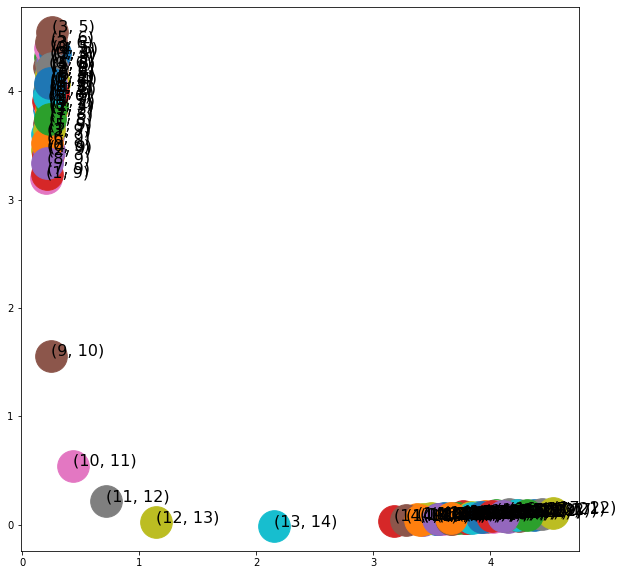

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():
    
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

plt.show()

## Graph2Vec

To specify, given a set of graphs, the Graph2Vec algorithms generate an embedding space where each point represents a graph. This algorithm generates its embedding using an evolution of the Word2Vec skip-gram model known as Document to Vector (Doc2Vec). We can graphically see a simplification of this model as follows:

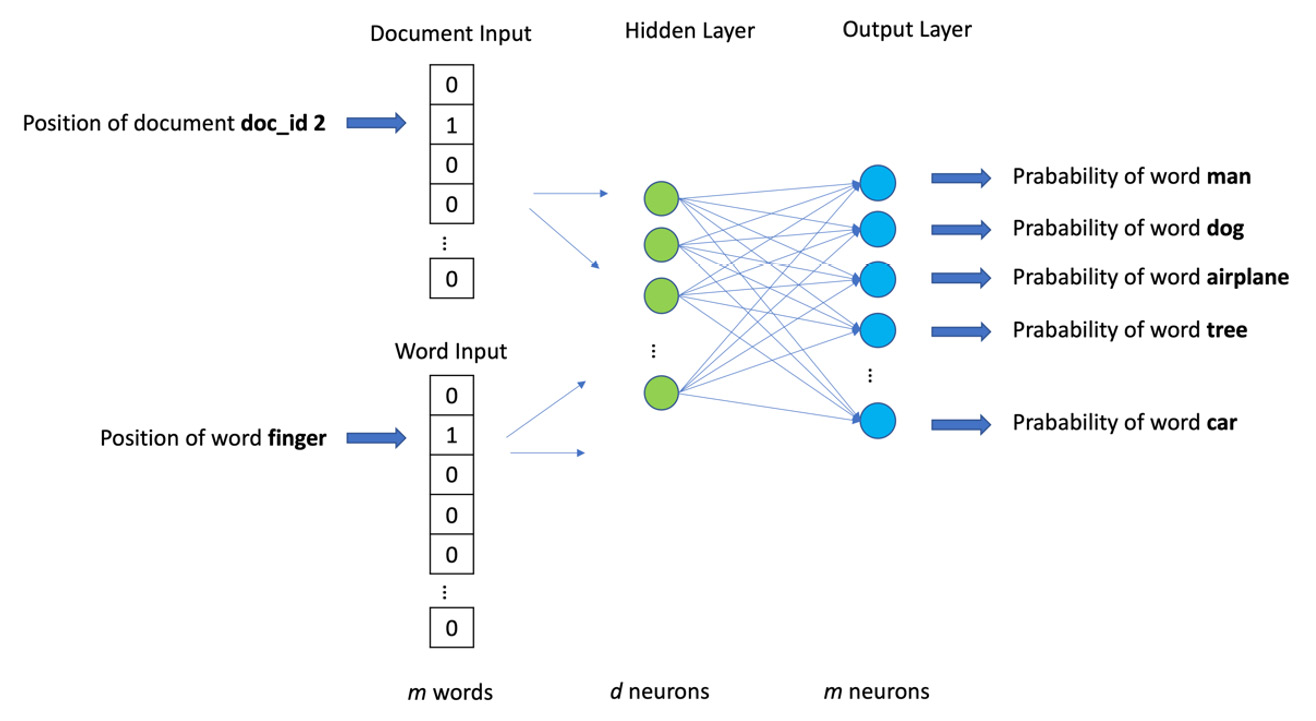

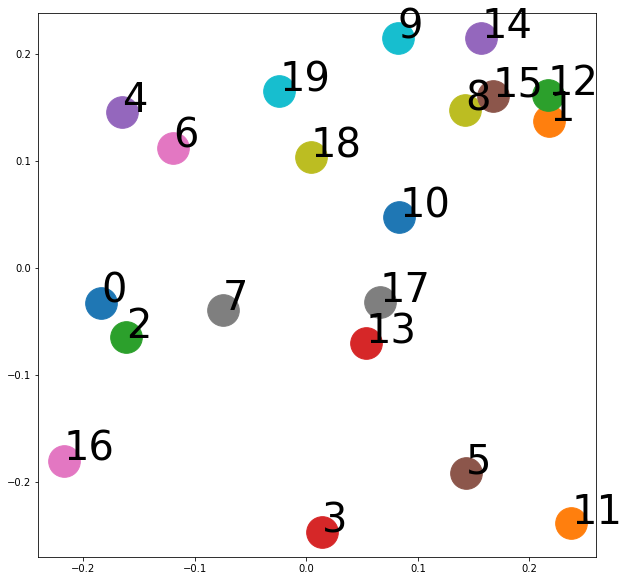

In [ ]:
n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10)
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(10,10))

for i,vec in enumerate(embeddings):
    
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=40)